# DQN: Reinforcement Learning on Atari Games

Created by Paul Scott<br>
MSE Computer and Information Science<br>
University of Pennsylvania<br>

# References

* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://keras.io/examples/rl/deep_q_network_breakout/
* https://github.com/mgbellemare/Arcade-Learning-Environment
* https://github.com/kenjyoung/MinAtar
* https://towardsdatascience.com/double-deep-q-networks-905dd8325412

# Setup

Download required packages

In [1]:
%%capture
!git clone https://github.com/kenjyoung/MinAtar.git
!pip install ./MinAtar
!pip install --upgrade gym
!pip install ale-py
!pip install torchinfo

Download ROMs for ALE environment

In [2]:
%%capture
!wget https://atariage.com/2600/roms/SpaceInvaders.zip
!wget https://www.atariage.com/2600/roms/MsPacMan.zip
!wget https://www.atariage.com/2600/roms/Breakout.zip

!mkdir roms/
!unzip SpaceInvaders.zip -d roms/
!unzip MsPacMan.zip -d roms/
!unzip Breakout.zip -d roms/
!mv roms/SPCINVAD.BIN roms/spaceinvaders.bin
!mv roms/MSPACMAN.BIN roms/mspacman.bin
!mv roms/Breakout.bin roms/breakout.bin

!ale-import-roms roms/

Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from ale_py import ALEInterface
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
from collections import namedtuple, deque
from itertools import count
from IPython import display
import math
import random
from PIL import Image
from torchinfo import summary
import numpy as np
import seaborn as sns
import time
import gym

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

# Environment Setup

Define base environment class

In [4]:
class AbstractEnvironment():
  def __init__(self, num_actions, state_shape, cmap=None, aspect=None):
    self.num_actions = num_actions
    self.state_shape = state_shape
    self.num_channels = state_shape[1]
    self.cmap = cmap
    self.aspect = aspect
    self.crop = None

  def reset(self):
    pass

  def step(self, action, skip=0):
    pass
  
  def render(self):
    pass

Define ALE environment

In [5]:
class ALEEnvironment(AbstractEnvironment):
  def __init__(self, game):
    self.env = ALEInterface()
    self.env.loadROM(game)
    self.env.setFloat('repeat_action_probability', 0)
    self.frame_stack = deque()
    self.action_space = self.env.getMinimalActionSet()
    super().__init__(len(self.action_space), (1, 4, 84, 84), aspect='auto')

  def reset(self, initial_delay=0):
    self.env.reset_game()
    for _ in range(initial_delay):
      self.env.act(0)
    self.frame_stack = deque([torch.zeros((84, 84))] * 3 + [self.get_frame()])
    return self.format_state(self.frame_stack)

  def step(self, action, skip=0):
    lives = self.env.lives()
    reward = self.env.act(self.action_space[action])
    for _ in range(skip):
      reward += self.env.act(self.action_space[action])
    self.frame_stack.popleft()
    self.frame_stack.append(self.get_frame())
    next_state = self.format_state(self.frame_stack)
    done = self.env.lives() != lives
    return next_state, reward, done

  def render(self):
    return self.env.getScreenRGB()

  def format_state(self, state):
    return torch.stack(tuple(state)).unsqueeze(0).to(device)

  def get_frame(self):
    screen = Image.fromarray(self.env.getScreenGrayscale())
    if self.crop:
      screen = screen.crop(self.crop)
    screen = screen.resize((84, 84), Image.BILINEAR)
    screen = torch.Tensor(np.asarray(screen)) / 255.0
    return screen.float()

Define MinAtar environment

In [6]:
class MinAtarEnvironment(AbstractEnvironment):
  def __init__(self, game):
    self.env = gym.make(f'MinAtar/{game}')
    state_shape = self.format_state(self.env.render(mode='array')).shape
    cmap = sns.color_palette("cubehelix", state_shape[1])
    cmap.insert(0, (0, 0, 0))
    cmap = colors.ListedColormap(cmap)
    super().__init__(self.env.action_space.n, state_shape, cmap=cmap)

  def reset(self):
    return self.format_state(self.env.reset())

  def step(self, action):
    next_state, reward, done, _ = self.env.step(action)
    next_state = self.format_state(next_state)
    return next_state, reward, done

  def render(self):
    return np.amax(self.env.render(mode='array') * \
        np.reshape(np.arange(self.num_channels) + 1, (1, 1, -1)), 2) + 0.5

  def format_state(self, state):
    return torch.tensor(state, device=device).permute(2, 0, 1).unsqueeze(0).float()

Select environment

In [8]:
# from ale_py.roms import Breakout
# env = ALEEnvironment(Breakout)

env = MinAtarEnvironment('Breakout-v1')

Crop and preview game (ALE only)

In [9]:
if type(env) == ALEEnvironment:
  width = env.env.getScreenDims()[1]
  height =  env.env.getScreenDims()[0]
  env.crop = (8, 32, width - 8, height - 16)

  plt.imshow(env.get_frame(), cmap='gray')
  plt.axis('off')
  plt.show()

# Deep Q-Network (DQN)

Define ALE DQN

In [10]:
class ALEDQN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(env.num_channels, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
    self.fc1 = nn.Linear(64*7*7, 512)
    self.fc2 = nn.Linear(512, env.num_actions)

  def forward(self, x):
    # 3x84x84
    x = F.relu(self.conv1(x))
    
    # 32x20x20
    x = F.relu(self.conv2(x))

    # 64x9x9
    x = F.relu(self.conv3(x))

    # 64x7x7
    x = F.relu(self.fc1(x.flatten(start_dim=1)))
    x = self.fc2(x)

    return x

Define MinAtar DQN

In [11]:
class MinAtarDQN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(env.num_channels, 32, 3, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
    self.fc1 = nn.Linear(64*2*2, 512)
    self.fc2 = nn.Linear(512, env.num_actions)
    self.maxpool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    # 4x10x10
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    
    # 32x5x5
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)

    # 64x2x2
    x = F.relu(self.fc1(x.flatten(start_dim=1)))
    x = self.fc2(x)

    return x

Select DQN

In [12]:
dqn_class = ALEDQN if type(env) == ALEEnvironment else MinAtarDQN
summary(dqn_class(), input_shape=env.state_shape)

Layer (type:depth-idx)                   Param #
MinAtarDQN                               --
├─Conv2d: 1-1                            1,184
├─Conv2d: 1-2                            18,496
├─Linear: 1-3                            131,584
├─Linear: 1-4                            1,539
├─MaxPool2d: 1-5                         --
Total params: 152,803
Trainable params: 152,803
Non-trainable params: 0

# Training

Define training functions

In [13]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
  def __init__(self, size):
    self.memory = deque([], maxlen=size)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

def train_dqn():
  global dqn, dqn_target, optimizer, replay_memory, batch_size

  if len(replay_memory) < batch_size:
    return

  # get batch of transitions from replay memory
  transitions = replay_memory.sample(batch_size)
  transition_batch = Transition(*zip(*transitions))

  # get next states that are not final states
  non_final_indices = torch.tensor([next_state is not None for next_state in transition_batch.next_state])
  non_final_next_states = torch.cat([next_state for next_state in transition_batch.next_state if next_state is not None])

  # separate transitions batch by state, action, reward
  state_batch = torch.cat(transition_batch.state)
  action_batch = torch.cat(transition_batch.action)
  reward_batch = torch.cat(transition_batch.reward)
  reward_batch[~non_final_indices] = -1.0

  # get current q values and calculate expected q values
  q_values = dqn(state_batch).gather(1, action_batch)
  next_q_values = torch.zeros(batch_size, device=device)
  next_q_values[non_final_indices] = dqn_target(non_final_next_states).max(1)[0].detach()
  expected_q_values = (next_q_values * gamma) + reward_batch

  # calculate loss
  loss = criterion(q_values, expected_q_values.unsqueeze(1))

  # update network
  optimizer.zero_grad()
  loss.backward()
  for param in dqn.parameters():
    param.grad.data.clamp_(-1, 1)
  optimizer.step()

def select_action(state):
  global epsilon, epsilon_random_frames, epsilon_greedy_frames, steps, dqn
  epsilon -= epsilon_interval / epsilon_greedy_frames
  epsilon = max(epsilon, epsilon_end)
  if random.random() > epsilon or steps < epsilon_random_frames:
    with torch.no_grad():
      return dqn(state).max(1)[1].view(1, 1)
  else:
    return torch.tensor([[random.randrange(env.num_actions)]], device=device, dtype=torch.long)

def plot_stats():
  global epsilon
  global episode_rewards
  display.clear_output(wait=True)
  plt.title('Episode Total Rewards')
  plt.xlabel(f'Episode')
  plt.ylabel('Reward')
  plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
  plt.show()
  print(f'Max Score: {max(episode_rewards)} | Epsilon: {epsilon}')

Train dqn

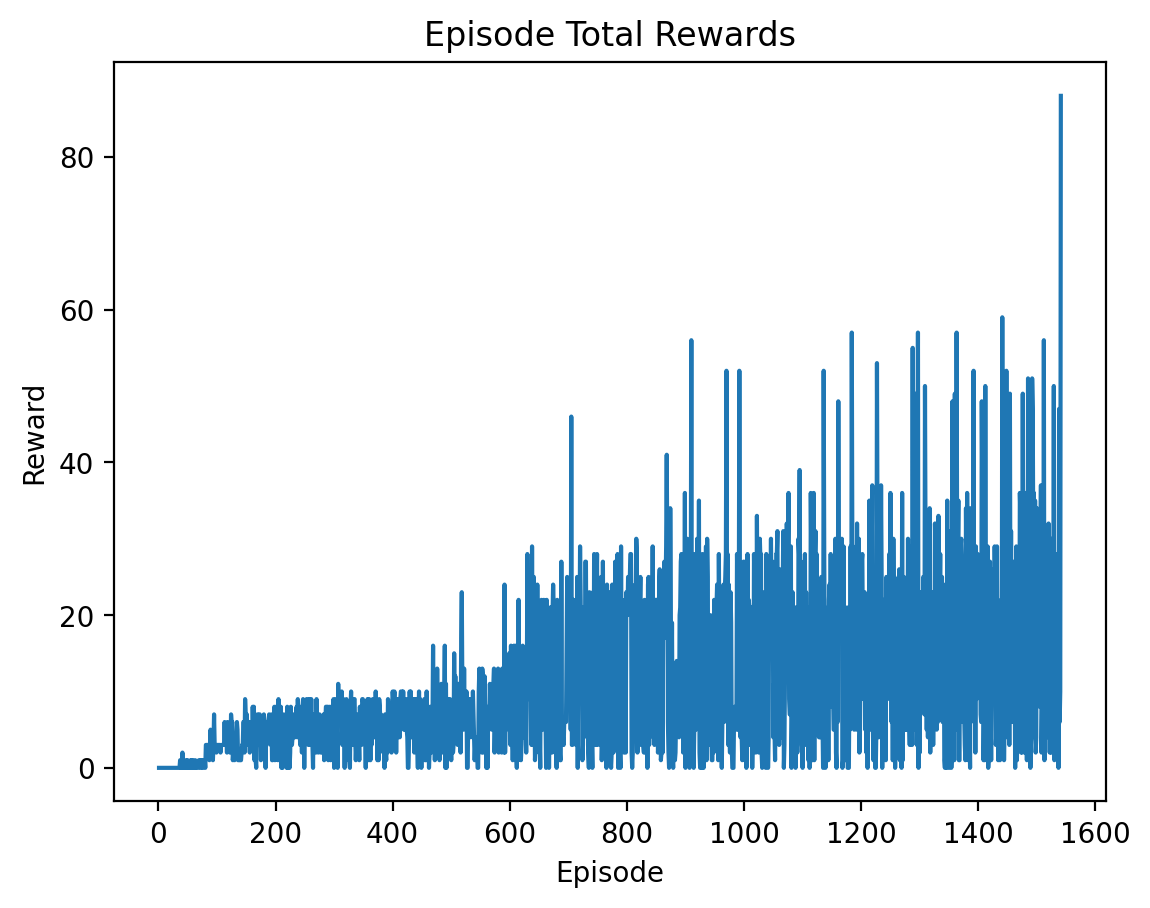

Max Score: 88 | Epsilon: 0.1


In [16]:
max_score = 60

batch_size = 128
gamma = 0.99
epsilon = 1.0
epsilon_end = 0.1
epsilon_interval = epsilon - epsilon_end
actions_per_update = 4
epsilon_random_frames = 5000
epsilon_greedy_frames = 100000
target_update = 1000
replay_memory_size = 100000

dqn = dqn_class().to(device)
dqn_target = dqn_class().to(device)
dqn_target.load_state_dict(dqn.state_dict())

replay_memory = ReplayMemory(replay_memory_size)
criterion = nn.HuberLoss()

optimizer = Adam(dqn.parameters(), lr=0.00025)

steps = 0
episode_rewards = []

for episode in count():
  state = env.reset()
  total_reward = 0

  for t in count():

    # select action using epsilon greedy strategy
    action = select_action(state)

    # perform action and get reward
    next_state, reward, done = env.step(action)
    total_reward += reward

    # add to replay memory
    next_state = None if done else next_state
    reward = torch.tensor([reward], device=device)
    replay_memory.push(state, action, next_state, reward)
    state = next_state

    # train dqn on data saved to replay memory
    if steps % actions_per_update == 0:
      train_dqn()

    # update target dqn with weights from main dqn
    if steps % target_update == 0:
      dqn_target.load_state_dict(dqn.state_dict())
    
    # check if game is over
    if done:
      episode_rewards.append(total_reward)
      if episode % 50 == 0:
        plot_stats()
      break

  # stop training once max score is reached
  if total_reward >= max_score:
    plot_stats()
    break

Save trained agent

In [17]:
torch.save(dqn.state_dict(), 'breakout_dqn.pt')
torch.save(dqn_target.state_dict(), 'breakout_dqn_target.pt')

# Results

Load trained agent

In [ ]:
dqn = dqn_class(env).to(device)
dqn_target = dqn_class(env).to(device)

dqn.load_state_dict(torch.load('breakout_dqn.pt'))
dqn_target.load_state_dict(torch.load('breakout_dqn_target.pt'))

Run game with trained agent

In [21]:
final_score = 60

total_reward = 0
while total_reward < final_score:
  total_reward = 0
  state = env.reset()
  frames = [env.render()]

  for t in count():
    action = torch.argmax(dqn(state))
    state, reward, done = env.step(action)
    total_reward += reward
    
    frames.append(env.render())
    
    if done or total_reward >= final_score:
      break

Visualize gameplay

In [22]:
fig, ax = plt.subplots()
fig.tight_layout(pad=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

def get_frame(index):
  ax.clear()
  return ax.imshow(frames[index], aspect=env.aspect, cmap=env.cmap)

plt.close()
animation.FuncAnimation(fig, get_frame, frames=len(frames), interval=50)

# Encode game into neural network

In [ ]:
class ROMNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    # next state embedding
    self.conv1 = nn.Conv2d(env.num_channels + env.num_actions, 32, 3, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
    self.fc1 = nn.Linear(64*2*2, 512)
    self.maxpool = nn.MaxPool2d(2, 2)

    # next frame generator
    self.convt1 = nn.ConvTranspose2d(512, 64, 5)
    self.convt2 = nn.ConvTranspose2d(64, env.num_channels, 3, padding=1)
    self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    
    # 4x10x10
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    
    # 32x5x5
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)

    # 64x2x2
    x = F.relu(self.fc1(x.flatten(start_dim=1)))

    # 512
    x = x.reshape(-1, 512, 1, 1)
    
    # 512x1x1
    x = F.relu(self.convt1(x))
  
    # 64x5x5
    x = self.sigmoid(self.upsample(F.relu(self.convt2(x))))

    return x

In [ ]:
rom = ROMNetwork().to(device)
optimizer = Adam(rom.parameters())
mse_loss = nn.MSELoss()

def state_to_screen(state):
  return np.amax(state * np.reshape(np.arange(env.num_channels) + 1, (1, 1, -1)), 2) + 0.5

def append_actions_to_states(actions, states):
  actions = torch.stack([F.one_hot(torch.tensor(action), env.num_actions).repeat((10, 10, 1)).permute(2, 0, 1) for action in actions])
  states_with_actions = torch.cat((states, actions), dim=1).float()
  return states_with_actions

def train_rom_network():
  transitions = replay_memory.sample(batch_size)
  transition_batch = Transition(*zip(*transitions))

  curr_states = torch.cat(transition_batch.state).float()
  next_states = [next_state if next_state != None else torch.zeros(1, env.num_channels, 10, 10, device=device) for next_state in transition_batch.next_state]
  next_states = torch.cat(next_states).float()

  actions = [torch.argmax(dqn(state.unsqueeze(0))) for state in curr_states]
  curr_states_with_actions = append_actions_to_states(actions, curr_states)

  optimizer.zero_grad()

  pred_next_states = rom(curr_states_with_actions)

  loss = mse_loss(next_states, pred_next_states)

  loss.backward()
  optimizer.step()

  return round(float(loss), 3)

In [ ]:
num_epochs = 1
batch_size = 1024

for epoch in range(num_epochs):
  for batch in range(len(replay_memory) // batch_size):
    print(f'\r{batch+1}/{len(replay_memory) // batch_size}', end='')
    loss = train_rom_network()
  print(f'\nEpoch {epoch+1} Loss: {loss}\n')

1/313

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


313/313
Epoch 1 Loss: 0.243



In [ ]:
steps = 100

state = env.reset()
frames = [env.render()]
rom.eval()

for _ in range(steps):
  action = torch.argmax(dqn(state)).unsqueeze(0)
  state_with_actions = append_actions_to_states(action, state)
  next_state = rom(state_with_actions)

  frames.append(state_to_screen(np.array(next_state.squeeze().permute(1, 2, 0).detach().cpu())))
  state = next_state

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
fig, ax = plt.subplots()
fig.tight_layout(pad=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

def get_frame(index):
  ax.clear()
  return ax.imshow(frames[index], aspect=env.aspect, cmap=env.cmap)

plt.close()
animation.FuncAnimation(fig, get_frame, frames=len(frames), interval=50)